#  <font color='green'>Projet 3 : Anticipez les besoins en consommation de bâtiments</font>

# Partie 2 : Modélisation de la consommation d'énergie

## Sommaire

1. Objectifs
2. Chargement des données
3. Préparation des données 
4. Modélisation en utilisant les hyperparamètres de base
5. Optimisation des modèles
6. Comparaison des meilleurs modèles

## 1. Objectifs

Prédire la **consommation totale d’énergie** de bâtiments non destinés à l’habitation de la ville de Seattle. La prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, etc). 

Etapes: 

1. Préparer les données pour la modèlisation.
    
2. Tester différents modèles de prédiction en utilisant les hyperparamètres de base sur les dataset differents:

   - avec la variable cible transformée en log et la variable cible non transformée.
   - avec la variable ENERGYSTARScore et sans cette variable sur le dataset de taille REDUIT
   - avec la variable ENERGYSTARScore complétée par ItitrativeImputer et sans cette variable sur le dataset COMPLET

3. Sélectionner les modèles avec les hyperparamètres de base les plus performants et conclure :

   - quelle variable cible à utiliser (transformée en log ou pas)
   - l'interêt d'utiliser la variable explicative ENERGYStarScore
   - modelisation sur le jeu de donnée complet ou reduit

4. Optimiser les modèles sélectionnés (GridSearch CV, Randomized Search CV)

5. Mettre en place une évaluation des performances et choisir le modèle final.

6. Analyser les améliorations possibles du modèle final (erreurs de prédictions,features importance etc)

## 2. Chargement des données

In [430]:
# importation des librairies

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import *
from matplotlib import *
import missingno as msno
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, \
    BayesianRidge, HuberRegressor, \
    OrthogonalMatchingPursuit, Lars, SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, \
    ExtraTreesRegressor, GradientBoostingRegressor, BaggingRegressor
from math import sqrt
from sklearn.pipeline import Pipeline
from math import sqrt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, RandomizedSearchCV, \
    GridSearchCV, learning_curve, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import *
import matplotlib.gridspec as gs
import time
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import matplotlib.gridspec as gs
from scipy.stats import loguniform
from category_encoders.target_encoder import TargetEncoder

In [431]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [432]:
# chargement du jeu de données nettoyé, après feature engineering

df = pd.read_csv('C:\\Users\\mfila\\df_batiment_model.csv')

In [433]:
# vérification des types de colonnes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1619 entries, 0 to 1618
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 1619 non-null   int64  
 1   BuildingType                  1619 non-null   object 
 2   PrimaryPropertyType           1619 non-null   object 
 3   ZipCode                       1619 non-null   float64
 4   CouncilDistrictCode           1619 non-null   int64  
 5   Neighborhood                  1619 non-null   object 
 6   NumberofBuildings             1619 non-null   int64  
 7   NumberofFloors                1619 non-null   int64  
 8   LargestPropertyUseType        1619 non-null   object 
 9   SecondLargestPropertyUseType  1619 non-null   object 
 10  ThirdLargestPropertyUseType   1619 non-null   object 
 11  ENERGYSTARScore               1080 non-null   float64
 12  SiteEnergyUseWN(kBtu)         1619 non-null   float64
 13  Out

In [434]:
# correction des types de variables

df['ZipCode'] = df['ZipCode'].astype(object)
df['CouncilDistrictCode'] = df['CouncilDistrictCode'].astype(object)

## 3. Préparation des données

Le jeu de données nettoyé contient 1619 lignes et 25 variables. Le but est que la prédiction de la consommation d'énergie se base sur les données structurelles des bâtiments. La deuxième variable cible, les émissions (TotalGHGEmissions), fortement corrélée avec la quantité d'énergie consommée, ne sera pas incluse.

Une de nos variables explicatives ENERGYSTARScore compte 539 valeurs absentes. 

avec la variable cible transformée en log et la variable cible non transformée.
avec la variable ENERGYSTARScore et sans cette variable sur le dataset de taille REDUIT
avec la variable ENERGYSTARScore complétée par ItitrativeImputer et sans cette variable sur le dataset COMPLET

Pour tester les differentes options de modélisation, nous allons créer 3 dataframes :

1. df1 : sans variable ENERGYSTARScore, dataset complet

2. df_small_e : avec variable ENERGYSTARScore, valeurs absentes pour cette variables sont supprimées, la taille de dataframe est donc reduite

3. df_e_imp : avec variable ENERGYSTARScore, valeurs absentes pour cette variables complétées par ItirativeImputer, dataset comlet

**Création du dataframe sans variable ENERGYSTARScore, dataset complet**

In [435]:
# création du dataframe df1 : sans variable ENERGYSTARScore, dataset complet

df1 = df.copy()
df1 = df1[['BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'NumberofBuildings',
       'NumberofFloors', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
        'BuildingAge','SiteEnergyUseWN(kBtu)','SiteEnergyUseWN(kBtu)_log',
       'TauxParkingGFA', 'TauxFirstUseGFA',
       'TauxSecondtUseGFA', 'TauxThirdtUseGFA', 'TauxSteamUse(kBtu)',
       'TauxElectricity(kBtu)', 'TauxNaturalGas(kBtu)',
       'PropertyGFABuilding(s)_log']]

**Création du dataframe avec variable ENERGYSTARScore, valeurs absentes sont supprimées, taille de dataframe reduite**

In [436]:
# création du dataframe df_small_e : avec variable ENERGYSTARScore, valeurs absentes sont supprimées, 
# taille de dataframe est reduite

df_small_e = df.copy()
df_small_e = df_small_e[['BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'NumberofBuildings',
       'NumberofFloors', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
        'BuildingAge','SiteEnergyUseWN(kBtu)','SiteEnergyUseWN(kBtu)_log',
       'TauxParkingGFA', 'TauxFirstUseGFA',
       'TauxSecondtUseGFA', 'TauxThirdtUseGFA', 'TauxSteamUse(kBtu)',
       'TauxElectricity(kBtu)', 'TauxNaturalGas(kBtu)',
       'PropertyGFABuilding(s)_log','ENERGYSTARScore']]
df_small_e = df_small_e.dropna()

**Création du dataframe avec variable ENERGYSTARScore, valeurs absentes complétées, dataset complet**

In [437]:
# variables à completer par IterativeImputer

ndf = df[['NumberofBuildings', 'NumberofFloors', 'BuildingAge','ENERGYSTARScore', 
           'TauxParkingGFA', 'TauxFirstUseGFA', 'TauxSecondtUseGFA', 'TauxThirdtUseGFA', 
          'TauxSteamUse(kBtu)', 'TauxElectricity(kBtu)', 'TauxNaturalGas(kBtu)', 'PropertyGFABuilding(s)_log']]

In [438]:
# IterativeImputer

imp = IterativeImputer(estimator=RandomForestRegressor(),imputation_order='ascending')

# Fit dataset avec des valeurs absentes

imp.fit(ndf)

# Transformation du dataset

df_imput = pd.DataFrame(imp.transform(ndf), columns = ndf.columns)

C:\Users\mfila\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [439]:
# vérification du remplissage des variables

df_imput.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1619 entries, 0 to 1618
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   NumberofBuildings           1619 non-null   float64
 1   NumberofFloors              1619 non-null   float64
 2   BuildingAge                 1619 non-null   float64
 3   ENERGYSTARScore             1619 non-null   float64
 4   TauxParkingGFA              1619 non-null   float64
 5   TauxFirstUseGFA             1619 non-null   float64
 6   TauxSecondtUseGFA           1619 non-null   float64
 7   TauxThirdtUseGFA            1619 non-null   float64
 8   TauxSteamUse(kBtu)          1619 non-null   float64
 9   TauxElectricity(kBtu)       1619 non-null   float64
 10  TauxNaturalGas(kBtu)        1619 non-null   float64
 11  PropertyGFABuilding(s)_log  1619 non-null   float64
dtypes: float64(12)
memory usage: 151.9 KB


C:\Users\mfila\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\mfila\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



Traitement de la variable  ENERGYSTARScore


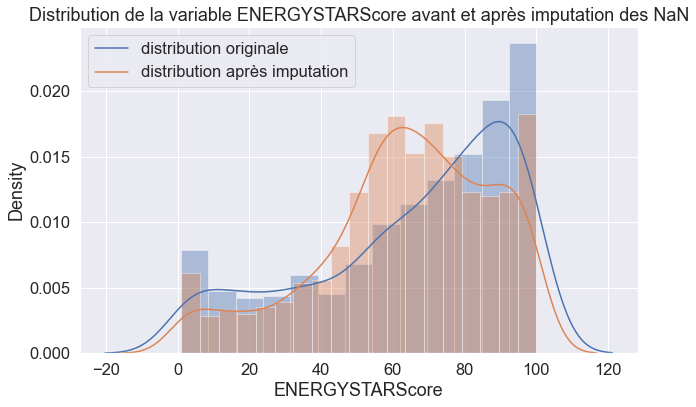

In [440]:
# distributions avant et après IterativeImputer

sns.set(font_scale=1.5)
for column in ['ENERGYSTARScore']:
    plt.figure(figsize=(10,6))
    chaine = 'Distribution de la variable ' + column + ' avant et après imputation des NaN'
    plt.title(chaine)
    
    sns.distplot(ndf[column])
    sns.distplot(df_imput[column])
    plt.legend(['distribution originale', 'distribution après imputation'])
    print('\nTraitement de la variable ',column)
sns.set(font_scale=1)

In [441]:
# remplacer les Nan par les nouvelles valeurs 

df_e_imputed = df_imput[['ENERGYSTARScore']]
df_e_imputed

,ENERGYSTARScore
0,60.000
1,61.000
2,43.000
3,56.000
4,75.000
...,...
1614,9.000
1615,69.560
1616,77.000
1617,57.640


In [442]:
df_e_imp = pd.concat([df1,df_e_imputed],axis=1)

**Preprocessing**

Nous avons créé plusieurs datasets afin de tester les differents modèles en fonction du feature engineering effectué.
Pour automatiser le prétraitement des données avant modélisation nous allons créer une fonction qui effectue :

- sépartion des données en entrées (matrice X) et de la variable cible (vecteur y).
- séparation des données en jeu d'entraînement et jeu de test.
- préparation des variables quantitatives à l'aide de RobustScaler, le choix de cette technique est lié à non normalité de distribution des variables quantitatives et permettrait de reduire l’influence des valeurs extrêmes. 
- préparation des variables qualitatives : encodage à l'aide de OneHotEncoder, qui crée des colonnes binaires 1 ou 0, et élimine un eventuel problème d'influence des valeurs ordinales sur les modèles.
- renvoie en sortie jeux de donéées d'entrainement et de test standartisées et encodées.

In [443]:
def preparation (X, y) :
    
    # Découpage du jeu de données en train et test
    
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
    print(f'X_train : {X_train.shape}, X_test : {X_test.shape}')
    print(f'y_train : {y_train.shape}, y_test : {y_test.shape}')
    
    # Standartisation

    numeric=X.select_dtypes('number').columns
    normalisation=RobustScaler()

    # Preprocessing OneHot    

    categ=X.select_dtypes('object').columns
    OneHot=OneHotEncoder(handle_unknown='ignore',sparse=False)

    preprocessor = ColumnTransformer(transformers=[ ('num', normalisation, numeric),
                                                ('cat', OneHot, categ)])
    
    # Apprentissage de l'encodage et transformation des données d'entrainement et de test

    X_train_std=preprocessor.fit_transform(X_train)
    X_test_std=preprocessor.transform(X_test)

    # Récupération des noms des variables encodeés
    
    encoded_names=numeric.to_list()
    encoded_cat_names=preprocessor.named_transformers_['cat'].get_feature_names_out(categ).tolist()
    encoded_names.extend(encoded_cat_names)

    # création du dataframe des données standartisées et encodées

    encoded_df_train=pd.DataFrame(X_train_std,columns=encoded_names)
    encoded_df_test=pd.DataFrame(X_test_std,columns=encoded_names)
    
    return X_train_std, X_test_std, y_train, y_test, encoded_df_train

## 4. Modélisation en utilisant les hyperparamètres de base

Nous allons tester plusieurs modèles de regression pour prèdire la consommation d'énergie en utilisant les hyperparamètres de base, en commençant par les modèles les plus simples.

D'abord, nous allons appliquer une approche naïve et tester le modèle DummyRegressor. Les résultats de ces premières prédictions serons utilisés comme baseline pour comparer les modèles. 

Nous allons ensuite tester les modèles plus compléxes de type regression linéaire (non régularisée et régularisée), modèles non-linéaires SVR(kernel='rbf'), méthodes ensemblistes (parallèle et séquentielle).

Le but est de conclure : 
- quelle variable cible à utiliser (transformée en log ou pas)
- l'interêt d'utiliser la variable explicative ENERGYStarScore
- modelisation sur le jeu de donnée complet ou reduit

**Fonction de comparaison des modèles**

Pour faciliter la comparaison des résultats de modèles nous allons créer une fonction qui calcule les differents métriques de performance et les saufgarde dans un dataframe.
Le choix de découper le jeu de données en 3 parties pour la validation croisée est lié à la taille du dataset(moyen), et le fait que les données ne sont pas homogènes.

In [444]:
def model_comp (model_to_comp, X_train_std, X_test_std, y_train, y_test) :
   
    df_comp = pd.DataFrame()
    from time import time
    for model in model_to_comp:
        start = time()
        model.fit(X_train_std, y_train.values.ravel())
        train_time = time() - start
        start = time()
        y_pred = model.predict(X_test_std)
        predict_time = time()-start    
        r2 = round(r2_score(y_test, y_pred),2)
        mse = mean_squared_error(y_test, y_pred)
        rmse = round(sqrt(mse),2)
        errors = abs(y_pred - y_test)

    
        # Cross validation
        scoring = ['r2']
        scores = cross_validate(model, X_train_std, y_train, cv=3,
                            scoring=scoring, return_train_score=True)
    
        # Performances de modèle
        df_comp = df_comp.append(pd.DataFrame({
         'Modèle': [model],
         'R2': [round(r2,2)],
         'RMSE': [round(rmse,2)],
         'Erreur moy': [round(np.mean(errors),2)],
         'Durée': [round(train_time, 5)],
         'Test R2 CV': [round(scores['test_r2'].mean(),2)],
         'Train R2 CV':[round(scores['train_r2'].mean(),2)],
         }), ignore_index=True)
    return(df_comp)

**Choix des modèles de base à tester**

In [445]:
model_to_comp = [
    DummyRegressor(strategy='median'),
    DummyRegressor(strategy='mean'),
    LinearRegression(),
    Ridge(random_state=0),
    HuberRegressor(),
    SVR(kernel='rbf'),
    BaggingRegressor(random_state=0),
    RandomForestRegressor(random_state=0),
    GradientBoostingRegressor(random_state=0),
    ExtraTreesRegressor(random_state=0)
]

**Test 1 : Modèles avec le jeu de données COMPLET SANS variable EnergyStarScore,target NON transformé**

In [446]:
# Definition de la variable cible et les features

df1_not_log = df1.copy()
df1_not_log.drop("SiteEnergyUseWN(kBtu)_log", axis=1,inplace=True)
target = ['SiteEnergyUseWN(kBtu)']

X = df1_not_log.iloc[:, ~df1_not_log.columns.isin(target)]
y = df1_not_log.loc[:,'SiteEnergyUseWN(kBtu)']

In [447]:
# Division en train et test

X_train_std, X_test_std, y_train, y_test, encoded_df = preparation(X,y)

X_train : (1295, 19), X_test : (324, 19)
y_train : (1295,), y_test : (324,)


In [448]:
# résultats de test 1

df_comp1 = model_comp(model_to_comp, X_train_std, X_test_std, y_train, y_test)
df_comp1

,Modèle,R2,RMSE,Erreur moy,Durée,Test R2 CV,Train R2 CV
0,DummyRegressor(strategy='median'),-0.050,25970793.200,7148670.180,0.001,-0.080,-0.070
1,DummyRegressor(),-0.000,25346112.540,9233125.600,0.000,-0.000,0.000
2,LinearRegression(),-42732823614293909504.000,165679564369908608.000,19453321257777336.000,0.067,-378470135201036632064.000,0.690
3,Ridge(random_state=0),0.510,17767545.200,7297025.990,0.025,0.230,0.670
4,HuberRegressor(),0.180,23016184.980,5462817.880,0.099,0.190,0.160
5,SVR(),-0.050,25970780.960,7148648.130,0.409,-0.080,-0.070
6,(DecisionTreeRegressor(random_state=2087557356...,0.530,17328659.400,4113136.370,0.497,0.500,0.900
7,"(DecisionTreeRegressor(max_features=1.0, rando...",0.550,17007593.300,4141992.780,4.685,0.530,0.930
8,([DecisionTreeRegressor(criterion='friedman_ms...,0.630,15343724.510,4126068.810,1.189,0.540,0.970
9,"(ExtraTreeRegressor(random_state=209652396), E...",0.610,15905508.560,4014888.990,4.949,0.440,1.000


Les modèles plus simples sont moins performants. 

Note : Valeur aberrante de R2 pour la régression linéaire decrit une situation quand une équation non standard est utilisée pour calculer R2 et le modèle correspond vraiment mal aux données, pire que l’ajustement d’une ligne horizontale.

**Test 2 : Modèles sur le jeu de données COMPLET SANS variable EnergyStarScore, target transformé en LOG**

In [449]:
# Definition de la variable cible et les features

df1_log = df1.copy()
df1_log.drop("SiteEnergyUseWN(kBtu)", axis=1,inplace=True)
target = ['SiteEnergyUseWN(kBtu)_log']

X = df1_log.iloc[:, ~df1_log.columns.isin(target)]
y = df1_log.loc[:,'SiteEnergyUseWN(kBtu)_log']

In [450]:
# Division en test et train

X_train_std, X_test_std, y_train, y_test, encoded_df = preparation(X,y)

X_train : (1295, 19), X_test : (324, 19)
y_train : (1295,), y_test : (324,)


In [451]:
# Résultats de test 2

df_comp2 = model_comp(model_to_comp, X_train_std, X_test_std, y_train, y_test)
df_comp2

C:\Users\mfila\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mfila\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mfila\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

,Modèle,R2,RMSE,Erreur moy,Durée,Test R2 CV,Train R2 CV
0,DummyRegressor(strategy='median'),-0.000,1.290,1.000,0.001,-0.010,-0.010
1,DummyRegressor(),-0.000,1.290,1.010,0.000,-0.010,0.000
2,LinearRegression(),-23375784791401304064.000,6231002712.920,731615260.050,0.053,-324458334414448951296.000,0.760
3,Ridge(random_state=0),0.730,0.660,0.510,0.006,0.690,0.750
4,HuberRegressor(),0.710,0.700,0.530,0.309,0.670,0.750
5,SVR(),0.740,0.660,0.510,0.368,0.670,0.780
6,(DecisionTreeRegressor(random_state=2087557356...,0.750,0.650,0.480,0.287,0.650,0.940
7,"(DecisionTreeRegressor(max_features=1.0, rando...",0.750,0.640,0.470,3.560,0.680,0.950
8,([DecisionTreeRegressor(criterion='friedman_ms...,0.760,0.640,0.470,1.294,0.690,0.850
9,"(ExtraTreeRegressor(random_state=209652396), E...",0.730,0.680,0.490,4.127,0.680,1.000


Les résultats de modèles avec la cible transformée en logarithme sont meilleurs par rapport à la modèlisation avec la cible non transformée. La difference dans les métriques de performance entre les modèles complexes et plus simples (regression linéaire régularisée, SVR) est comparable dans le cas de modélisation avec la cible transformée.

**Pour les modélisations suivantes nous allons utiliser uniquement le target transformé en logarithme.**

**Test 3 : Modèles sur le jeu de données REDUIT SANS variable EnergyStarScore, target transformé en LOG**

In [452]:
# Definition de la variable cible et les features

df_small_not_e = df_small_e.copy()
df_small_not_e.drop(["SiteEnergyUseWN(kBtu)","ENERGYSTARScore"], axis=1,inplace=True)
target = ['SiteEnergyUseWN(kBtu)_log']

X = df_small_not_e.iloc[:, ~df_small_not_e.columns.isin(target)]
y = df_small_not_e.loc[:,'SiteEnergyUseWN(kBtu)_log']

In [453]:
# Division en train et test

X_train_std, X_test_std, y_train, y_test, encoded_df = preparation(X,y)

X_train : (864, 19), X_test : (216, 19)
y_train : (864,), y_test : (216,)


In [454]:
# Résultats de test 3

df_comp3 = model_comp(model_to_comp, X_train_std, X_test_std, y_train, y_test)

C:\Users\mfila\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mfila\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mfila\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

In [455]:
df_comp3

,Modèle,R2,RMSE,Erreur moy,Durée,Test R2 CV,Train R2 CV
0,DummyRegressor(strategy='median'),-0.010,1.310,1.040,0.000,-0.010,-0.010
1,DummyRegressor(),-0.000,1.300,1.060,0.000,-0.010,0.000
2,LinearRegression(),-2118856812870020864.000,1892509453.350,201939948.050,0.032,-1058437881668689199104.000,0.840
3,Ridge(random_state=0),0.740,0.660,0.480,0.000,0.760,0.830
4,HuberRegressor(),0.730,0.680,0.490,0.207,0.760,0.830
5,SVR(),0.720,0.690,0.510,0.164,0.730,0.840
6,(DecisionTreeRegressor(random_state=2087557356...,0.740,0.660,0.490,0.251,0.720,0.950
7,"(DecisionTreeRegressor(max_features=1.0, rando...",0.740,0.660,0.480,2.099,0.740,0.970
8,([DecisionTreeRegressor(criterion='friedman_ms...,0.740,0.660,0.480,0.766,0.770,0.900
9,"(ExtraTreeRegressor(random_state=209652396), E...",0.740,0.670,0.490,2.353,0.730,1.000


Les résultats des modéles sont meilleurs sur le jeu de données reduit par rapport au jeu complet.

**Test 4 : Modèles sur le jeu de données REDUIT AVEC variable EnergyStarScore, target transformé en LOG**

In [456]:
# Definition de la variable cible et les features

df_small_with_e = df_small_e.copy()
df_small_with_e.drop(["SiteEnergyUseWN(kBtu)"], axis=1,inplace=True)
target = ['SiteEnergyUseWN(kBtu)_log']

X = df_small_with_e.iloc[:, ~df_small_with_e.columns.isin(target)]
y = df_small_with_e.loc[:,'SiteEnergyUseWN(kBtu)_log']

In [457]:
# Division en train et test

X_train_std, X_test_std, y_train, y_test, encoded_df = preparation(X,y)

X_train : (864, 20), X_test : (216, 20)
y_train : (864,), y_test : (216,)


In [458]:
# Résultats de test 4

df_comp4 = model_comp(model_to_comp, X_train_std, X_test_std, y_train, y_test)

C:\Users\mfila\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mfila\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mfila\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

In [459]:
df_comp4

,Modèle,R2,RMSE,Erreur moy,Durée,Test R2 CV,Train R2 CV
0,DummyRegressor(strategy='median'),-0.010,1.310,1.040,0.000,-0.010,-0.010
1,DummyRegressor(),-0.000,1.300,1.060,0.008,-0.010,0.000
2,LinearRegression(),-252832366803759296.000,653737786.260,76286117.470,0.035,-559314982318069972992.000,0.920
3,Ridge(random_state=0),0.850,0.510,0.340,0.004,0.870,0.910
4,HuberRegressor(),0.820,0.550,0.350,0.238,0.860,0.910
5,SVR(),0.840,0.530,0.350,0.154,0.810,0.900
6,(DecisionTreeRegressor(random_state=2087557356...,0.810,0.570,0.390,0.238,0.810,0.970
7,"(DecisionTreeRegressor(max_features=1.0, rando...",0.830,0.540,0.370,2.251,0.830,0.980
8,([DecisionTreeRegressor(criterion='friedman_ms...,0.860,0.480,0.340,0.898,0.870,0.960
9,"(ExtraTreeRegressor(random_state=209652396), E...",0.830,0.530,0.370,2.408,0.830,1.000


La présence de la variable ENERGYSTARScore améliore les résultats des modèles de 0.1 environ pour le R2 de test.

**Test 5 : Modèles sur le jeu de données COMPLET AVEC variable EnergyScore imputé par ItirativeImputer, target transformé en LOG**

In [461]:
# Definition de la variable cible et les features

df_with_e_imp = df_e_imp.copy()
df_with_e_imp.drop(["SiteEnergyUseWN(kBtu)"], axis=1,inplace=True)
target = ['SiteEnergyUseWN(kBtu)_log']

X = df_with_e_imp.iloc[:, ~df_with_e_imp.columns.isin(target)]
y = df_with_e_imp.loc[:,'SiteEnergyUseWN(kBtu)_log']

In [462]:
# Division en train et test

X_train_std, X_test_std, y_train, y_test, encoded_df = preparation(X,y)

X_train : (1295, 20), X_test : (324, 20)
y_train : (1295,), y_test : (324,)


In [463]:
# Résultats de test 5

df_comp5 = model_comp(model_to_comp, X_train_std, X_test_std, y_train, y_test)

C:\Users\mfila\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mfila\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mfila\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

In [464]:
df_comp5

,Modèle,R2,RMSE,Erreur moy,Durée,Test R2 CV,Train R2 CV
0,DummyRegressor(strategy='median'),-0.000,1.290,1.000,0.000,-0.010,-0.010
1,DummyRegressor(),-0.000,1.290,1.010,0.000,-0.010,0.000
2,LinearRegression(),-472474363676110528.000,885857700.250,106805785.180,0.035,-5212341578535244800.000,0.810
3,Ridge(random_state=0),0.790,0.590,0.430,0.008,0.760,0.810
4,HuberRegressor(),0.770,0.620,0.440,0.292,0.740,0.800
5,SVR(),0.790,0.590,0.410,0.455,0.740,0.830
6,(DecisionTreeRegressor(random_state=2087557356...,0.760,0.630,0.450,0.446,0.700,0.940
7,"(DecisionTreeRegressor(max_features=1.0, rando...",0.780,0.610,0.430,4.157,0.730,0.960
8,([DecisionTreeRegressor(criterion='friedman_ms...,0.800,0.580,0.410,1.345,0.760,0.890
9,"(ExtraTreeRegressor(random_state=209652396), E...",0.770,0.620,0.440,4.570,0.730,1.000


La présence de la variable ENERGYSTARScore complétée par ItirativeImputer améliore les résultats des modèles pour le jeu données complét (amélioration de R2 CV de test de 0.05).

Les premières modélisations avec les hyperparamétres de base nous montre que résultats de prediction s'améliorent avec 

1. Le target exprimé en log par rapport à la variable cible brute non transformée, surtout pour les algorithmes plus simples
2. Avec la présence de la variable explicative ENERGYSTARScore par rapport à la modèlisation sans cette variable.
3. Dans le cas de modèlisation sur le jeu de données reduit par rapport au jeu de données complet.

Néanmoins, pour les futures améliorations des modèles nous allons utiliser le jeu de données complet parce que notre modèle doit être efficace sur la grande varieté des nouvelles données notamment.

**Résultats des meuilleurs modèles avec les hyperparamètres de base**

Pour comparer les modèles avec les hyperparamétres de base nous nous basons sur les résultats de test 5, donc:
- la variable cible transformée en log
- le jeu de données complet
- la variable explicative ENERGYSTARScore complétée par ItirativeImputer.

In [465]:
# création du dataframe pour comparer les modèles

best_first_model = df_comp5.copy()
best_first_model['Modèle'] = ["DummyRegressor(median)",
 "DummyRegressor(mean)",
 "LinearRegression",
 "Ridge",
 "HuberRegressor",
 "SVR",
 "BaggingRegressor",
 "RandomForestRegressor",
 "GradientBoostingRegressor",
 "ExtraTreesRegressor"]

In [466]:
best_first_model = best_first_model.sort_values(by=['R2',"Test R2 CV", 'Durée'],ascending=False)
best_first_model.round(2)

,Modèle,R2,RMSE,Erreur moy,Durée,Test R2 CV,Train R2 CV
8,GradientBoostingRegressor,0.800,0.580,0.410,1.340,0.760,0.890
3,Ridge,0.790,0.590,0.430,0.010,0.760,0.810
5,SVR,0.790,0.590,0.410,0.450,0.740,0.830
7,RandomForestRegressor,0.780,0.610,0.430,4.160,0.730,0.960
4,HuberRegressor,0.770,0.620,0.440,0.290,0.740,0.800
9,ExtraTreesRegressor,0.770,0.620,0.440,4.570,0.730,1.000
6,BaggingRegressor,0.760,0.630,0.450,0.450,0.700,0.940
0,DummyRegressor(median),-0.000,1.290,1.000,0.000,-0.010,-0.010
1,DummyRegressor(mean),-0.000,1.290,1.010,0.000,-0.010,0.000
2,LinearRegression,-472474363676110528.000,885857700.250,106805785.180,0.030,-5212341578535244800.000,0.810


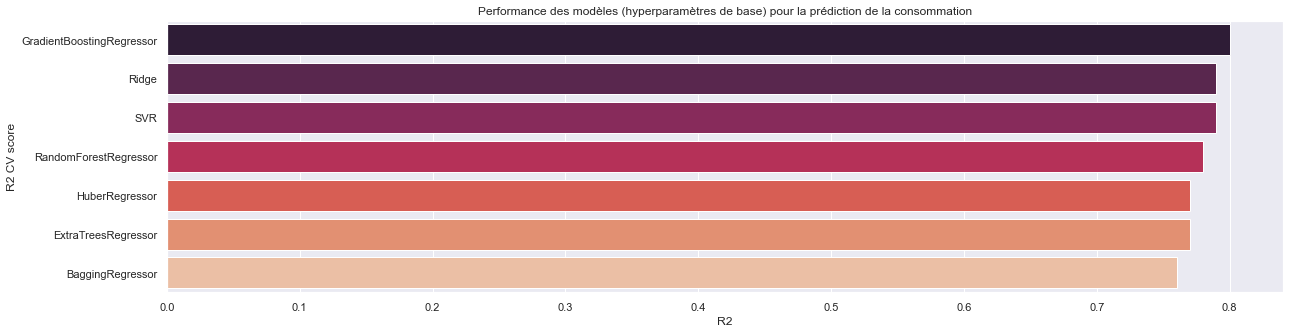

In [470]:
# Evaluation visualisation

best_first_model.drop(best_first_model[best_first_model['Test R2 CV'] < 0].index,
                inplace=True)

fig = plt.figure(figsize=(20, 5))
best_model_graph = best_first_model.sort_values(by=['R2'],
                                                ascending=False)
sns.barplot(data=best_model_graph,
            y='Modèle',
            x='R2',
            palette='rocket')
plt.ylabel('R2 CV score')
plt.title('Performance des modèles (hyperparamètres de base) pour la prédiction de la consommation')
plt.show()

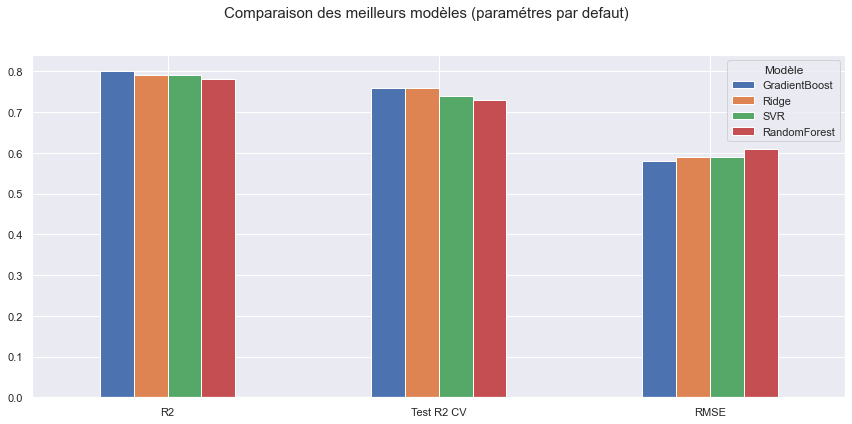

In [471]:
# Comparaison des scores R2, MSE, RMSE, MAE et erreur moyenne
df_score = best_first_model[['R2', 'Test R2 CV', 'RMSE']].head(4)

fig = plt.figure(figsize=(12, 6))

# Set properties of the figure
fig.suptitle(
    'Comparaison des meilleurs modèles (paramétres par defaut)', fontsize=15)

# Set the geometry of the grid of subplots
gs = gs.GridSpec(nrows=1, ncols=1,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
df_score.T.plot.bar(ax=ax1)

# Rotation of ticks labels
plt.setp(ax1.get_xticklabels(), rotation='horizontal')
plt.legend(['GradientBoost','Ridge','SVR','RandomForest'], title='Modèle') 

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.96])

<AxesSubplot:ylabel='Modèle'>

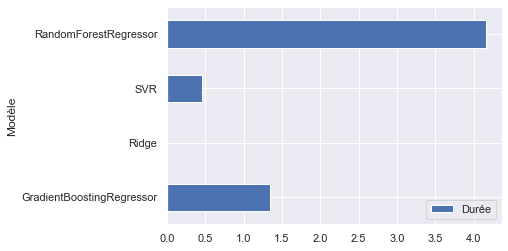

In [501]:
# Comparaison de la durée d'entraînement

df_duree = best_first_model[['Durée', 'Modèle']].head(4)
df_duree.plot.barh('Modèle','Durée')

Le modèle GradientBoostingRegressor détient la MSE la plus faible et le meilleur score R2. Le modèle Ridge a des performances similaires d'un point de vue la qualité de prédiction mais est avantageuse d'un point de vue de la durée d'entrainement. Nous allons optimiser ces modèles.

## 5. Optimisation des modèles

### GradientBoostingRegressor

L’algorithme de Gradient Boosting est un ensemble de « weak learners », créés les uns après les autres, formant un strong learner. De plus, chaque « weak learner » est entraîné pour corriger les erreurs des « weak learners » précédents. Les « weak learners » ont tous autant de poids dans le système de votation, peu importe leur performance. 

Les paramètres du GradientBoost sont couplés, nous ne pouvons pas les définir les uns après les autres. Les paramètres importants sont n_estimators, learning_rate et max_depth ou max_leaf_nodes.

Le nombre d’estimateurs (n_estimators) montre le nombr d'arbres à créer. Plus il y a d’arbres, plus ils sont susceptibles d'overfitting. 

max_depth (profonduer d'arbre) : avoir des apprenants très faibles à chaque étape aidera à réduire le surajustement. Plus les arbres sont profonds, plus les résidus seront corrigés rapidement et moins d’apprenants seront nécessaires. Par conséquent, n_estimators devrait être augmentée si max_depth diminue.

learning_rate: Une petite valeur de learning_rate ne corrigerait que les résidus de très peu d’échantillons. Si learning_rate élevé est défini (p. ex., 1), nous ajusterons les résidus de tous les échantillons. Ainsi, avec un learning_rate très faible, nous aurons besoin de plus d’estimateurs pour corriger l’erreur globale. Cependant, un learning_rate trop important tend à obtenir un ensemble surajusté, semblable à une trop grande profondeur d’arbre.

In [506]:
# Paramètres de base d'algorthme GradientBoostingRegressor

gradient_boost_base = GradientBoostingRegressor(random_state=0)
gradient_boost_base.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [507]:
# Definition de la variable cible et les features

df_with_e_imp = df_e_imp.copy()
df_with_e_imp.drop(["SiteEnergyUseWN(kBtu)"], axis=1,inplace=True)
target = ['SiteEnergyUseWN(kBtu)_log']

X = df_with_e_imp.iloc[:, ~df_with_e_imp.columns.isin(target)]
y = df_with_e_imp.loc[:,'SiteEnergyUseWN(kBtu)_log']

In [508]:
# Division en train et test, standartisation, encodage

X_train_std, X_test_std, y_train, y_test, encoded_df = preparation(X,y)

X_train : (1295, 20), X_test : (324, 20)
y_train : (1295,), y_test : (324,)


Nous allons utiliser une recherche automatique des hyperparamétres qui permettrait de tester les différentes valeurs par paramètre combinées entre elles (RandomizedSearchCV, GridSearchCV) pour ensuite comparer les résultats des modèles optimisés avec le modèle de base.

**RandomizedSearchCV**

In [510]:
# choix des paramètres et métriques de performance

param_distributions = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": loguniform(0.01, 1),
}
search_cv = RandomizedSearchCV(
    GradientBoostingRegressor(), param_distributions=param_distributions,
    scoring="r2", n_iter=100, random_state=0, n_jobs=-1
)
search_cv.fit(X_train_std, y_train)
y_pred = search_cv.predict(X_test_std)

columns = [f"param_{name}" for name in param_distributions.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results["mean_test_error"] = -cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results["R2_train"] = search_cv.score(X_train_std, y_train)
cv_results["R2_test"] = search_cv.score(X_test_std, y_test)
cv_results[columns].sort_values(by="mean_test_error")

,param_n_estimators,param_max_leaf_nodes,param_learning_rate,mean_test_error,std_test_error
10,200,20,0.110,-0.779,0.017
12,200,50,0.111,-0.777,0.021
65,200,20,0.137,-0.775,0.019
75,500,20,0.100,-0.774,0.013
63,200,5,0.104,-0.774,0.020
...,...,...,...,...,...
14,1,10,0.082,-0.080,0.019
36,2,20,0.034,-0.063,0.019
62,5,2,0.020,-0.062,0.019
28,5,5,0.011,-0.042,0.019


In [511]:
# meilleur résultat avec les hyperparamétres optimisés

search_cv.best_score_

0.778803913165589

In [512]:
# paramétres d'optimisation

search_cv.best_params_

{'learning_rate': 0.1098891866898283,
 'max_leaf_nodes': 20,
 'n_estimators': 200}

In [513]:
# saufgarder le modéle optimisé par RandomSearchCV

GBR_random_search_best = GradientBoostingRegressor(learning_rate = 0.109, max_leaf_nodes = 20,
 n_estimators =200)

**GridSearchCV**

In [514]:
from sklearn.model_selection import KFold
crossvalidation=KFold(n_splits=3,shuffle=True,random_state=0)

In [515]:
# choix des hyperparamétres

GBR=GradientBoostingRegressor(random_state=0)
search_grid={'n_estimators':[1,2,5,10,100,500],'learning_rate':[.001,0.015,0.01,.1],'max_depth':[1,2,4,10,20,50],
             'subsample':[.5,.75,1],'random_state':[0]}
search=GridSearchCV(estimator=GBR,param_grid=search_grid,scoring='r2',cv=crossvalidation)

In [516]:
# recherche des meilleurs hyperparamétres

search.fit(X_train_std,y_train)

# meilleur score
search.best_score_

0.77014223422532

In [517]:
# paramétres d'optimisation

search.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 500,
 'random_state': 0,
 'subsample': 0.5}

In [518]:
# saufgarder le modéle optimisé par GridSearch

GBR_grid_search_best = GradientBoostingRegressor(learning_rate= 0.1,
 max_depth= 2,
 n_estimators= 500,
 random_state= 0,
 subsample= 0.5)

In [519]:
GBR_grid_search_best.fit(X_train_std,y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=500, random_state=0,
                          subsample=0.5)

**Comparaison des modèles GradientBoost améliorés et le modèle de GradientBoost avec les paramétres de base**

In [520]:
GBR_models = [GradientBoostingRegressor(random_state = 0), GBR_random_search_best, GBR_grid_search_best]

In [521]:
df_GBR_comp = pd.DataFrame()

In [522]:
df_GBR_comp = model_comp(GBR_models, X_train_std, X_test_std, y_train, y_test)
df_GBR_comp['Modèle'] = ['GradientBoost_base','GBR_random_search_best','GBR_grid_search_best']

In [523]:
df_GBR_comp

,Modèle,R2,RMSE,Erreur moy,Durée,Test R2 CV,Train R2 CV
0,GradientBoost_base,0.800,0.580,0.410,0.644,0.760,0.890
1,GBR_random_search_best,0.800,0.570,0.400,1.229,0.770,0.930
2,GBR_grid_search_best,0.810,0.560,0.410,1.298,0.770,0.930


Pas d'amélioration significative du modèle GradienBoost suite à l'optimisation des hyperparamétres.

### Optimisation du modèle RIDGE

Pour le modèle Ridge nous allons chercher d'optimiser le hyperparamètre alpha, à default=1.

In [524]:
# modèle de base
Ridge=Ridge(random_state=0)

# paramétres
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)

# recherche
search = GridSearchCV(estimator=Ridge,param_grid=grid,scoring='r2',cv=crossvalidation, n_jobs=-1)

In [525]:
# fit
search.fit(X_train_std,y_train)

# meilleur score
search.best_score_

0.7563325426797799

In [526]:
# hyperparamètres optimisés

search.best_params_

{'alpha': 0.99}

In [529]:
# Saufgarder le meilleur modèle optimisé

Ridge_grid_search_best = Ridge(alpha=0.99, random_state=0)

In [530]:
Ridge_grid_search_best.fit(X_train_std,y_train)

Ridge(alpha=0.99, random_state=0)

**Comparaison des modèles Ridge améliorés et le modèle de Ridge avec les paramétres de base**

In [531]:
Ridge_models = [Ridge(random_state = 0), Ridge_grid_search_best]

In [532]:
df_Ridge_comp = pd.DataFrame()

In [533]:
df_Ridge_comp = model_comp(Ridge_models, X_train_std, X_test_std, y_train, y_test)
df_Ridge_comp['Modèle'] = ['Ridge_base','Ridge_grid_search_best']

In [534]:
df_Ridge_comp

,Modèle,R2,RMSE,Erreur moy,Durée,Test R2 CV,Train R2 CV
0,Ridge_base,0.790,0.590,0.430,0.009,0.760,0.810
1,Ridge_grid_search_best,0.790,0.590,0.430,0.006,0.760,0.810


L'hyperparamètre alpha issu d'optimisation par GridSearch est très proche au paramètre par défaut, il n y a pas d'amélioration significative du modèle Ridge suite cette optimisation.

### Optimisation du modèle RandomForestRegressor ###

In [537]:
# Paramètres de base d'algorthme RandomForestRegressor

random_forest_param = RandomForestRegressor(random_state = 0)
random_forest_param.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

**RandomSearch**

In [538]:
param_distributions = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    'bootstrap': [True],
    'max_depth': [3, 5, 8, 10],
}
search_cv = RandomizedSearchCV(
    RandomForestRegressor(), param_distributions=param_distributions,
    scoring="r2", n_iter=100, random_state=0, n_jobs=-1
)
search_cv.fit(X_train_std, y_train)

columns = [f"param_{name}" for name in param_distributions.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results["mean_test_error"] = -cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results[columns].sort_values(by="mean_test_error")

,param_n_estimators,param_max_leaf_nodes,param_bootstrap,param_max_depth,mean_test_error,std_test_error
66,200,100,True,8,-0.725,0.027
35,100,100,True,8,-0.724,0.024
12,500,100,True,8,-0.724,0.026
75,50,100,True,8,-0.718,0.022
85,100,50,True,8,-0.717,0.025
...,...,...,...,...,...,...
51,2,2,True,8,-0.405,0.054
76,1,2,True,5,-0.398,0.042
10,2,2,True,5,-0.396,0.065
74,1,2,True,10,-0.389,0.046


In [539]:
# meilleur score 
search_cv.best_score_

0.724512741952929

In [540]:
# meilleurs paramétres
search_cv.best_params_

{'n_estimators': 200, 'max_leaf_nodes': 100, 'max_depth': 8, 'bootstrap': True}

In [541]:
# saufgarder le meilleur modèle optimisé
RF_random_search_best = RandomForestRegressor(n_estimators=200, max_leaf_nodes=100, max_depth=8, bootstrap=True,random_state = 0)

**GridSearch**

In [542]:
RF=RandomForestRegressor(random_state=0)
search_grid={'n_estimators':[1,2,5,10,100,500],'max_leaf_nodes':[2,5,10,20,50],'max_depth':[1,2,5,10,20,50],
             'random_state':[0]}
search=GridSearchCV(estimator=RF,param_grid=search_grid,scoring='r2',cv=crossvalidation,error_score='raise')

In [543]:
search.fit(X_train_std,y_train)
search.best_score_

0.7130872504418898

In [544]:
search.best_params_

{'max_depth': 10, 'max_leaf_nodes': 50, 'n_estimators': 500, 'random_state': 0}

In [545]:
RF_grid_search_best = RandomForestRegressor(
 max_depth= 10,
 n_estimators= 500,
 random_state= 0,
 max_leaf_nodes = 50)

In [546]:
RF_random_search_best.fit(X_train_std,y_train)

RandomForestRegressor(max_depth=8, max_leaf_nodes=100, n_estimators=200,
                      random_state=0)

**Comparaison des modèles RandomForest améliorés et le modèle de RandomForest avec les hyperparamétres de base**

In [547]:
RF_models = [RandomForestRegressor(random_state = 0), RF_random_search_best, RF_grid_search_best]

In [548]:
df_RF_comp = pd.DataFrame()

In [549]:
df_RF_comp = model_comp(RF_models, X_train_std, X_test_std, y_train, y_test)
df_RF_comp['Modèle'] = ['RandomForest_base','RF_random_search_best', 'RF_grid_search_best']

In [550]:
df_RF_comp

,Modèle,R2,RMSE,Erreur moy,Durée,Test R2 CV,Train R2 CV
0,RandomForest_base,0.780,0.610,0.430,1.890,0.730,0.960
1,RF_random_search_best,0.770,0.620,0.450,2.763,0.720,0.900
2,RF_grid_search_best,0.760,0.640,0.460,5.566,0.720,0.880


Pas d'amélioration des résultats avec les hyperparamètres optimisés pour le modèle RandomForest.

## 6. Comparaison des meilleurs modèles

Nous allons comparer les résultats de 4 modèles : DummyRegressor comme baseline, modèle RandomForestRegresor avec les hyperparamétres de base, Ridge et GradientBoost optimisé à l'aide de GridSearch.

In [551]:
# meilleurs modèles à comparer

finalregressors = [DummyRegressor(strategy='median'),RandomForestRegressor(random_state = 0), Ridge_grid_search_best, GBR_grid_search_best]

In [552]:
# dataframe des résultats

df_best = pd.DataFrame()
df_best = model_comp(finalregressors, X_train_std, X_test_std, y_train, y_test)
df_best['Modèle'] = ['DummyRegressor(median)','RandomForest_base','Ridge_grid_search_best', 'GBR_grid_search_best']
df_best

,Modèle,R2,RMSE,Erreur moy,Durée,Test R2 CV,Train R2 CV
0,DummyRegressor(median),-0.000,1.290,1.000,0.001,-0.010,-0.010
1,RandomForest_base,0.780,0.610,0.430,2.025,0.730,0.960
2,Ridge_grid_search_best,0.790,0.590,0.430,0.005,0.760,0.810
3,GBR_grid_search_best,0.810,0.560,0.410,1.274,0.770,0.930


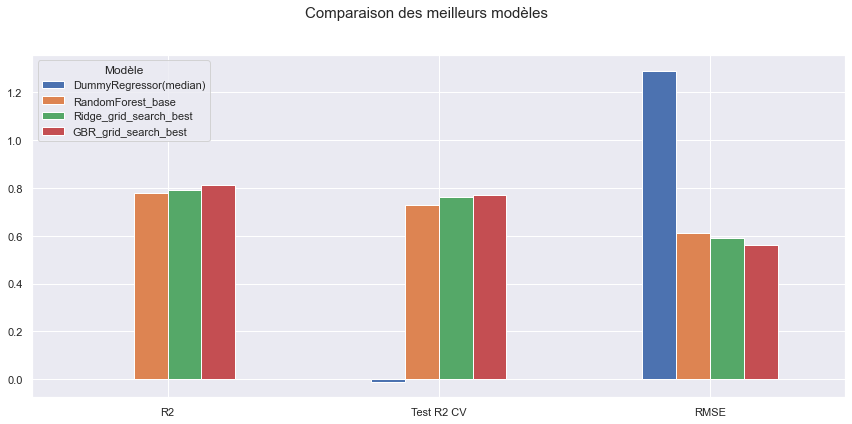

In [558]:
# Comparaison des scores R2, MSE, RMSE, MAE et erreur moyenne
df_score = df_best[['R2', 'Test R2 CV', 'RMSE']]

fig = plt.figure(figsize=(12, 6))

# Set properties of the figure
fig.suptitle(
    'Comparaison des meilleurs modèles', fontsize=15)

# Set the geometry of the grid of subplots
gs = gs.GridSpec(nrows=1, ncols=1,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
df_score.T.plot.bar(ax=ax1)

# Rotation of ticks labels
plt.setp(ax1.get_xticklabels(), rotation='horizontal')
plt.legend(['DummyRegressor(median)','RandomForest_base','Ridge_grid_search_best', 'GBR_grid_search_best'], title='Modèle') 

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.96])

<AxesSubplot:ylabel='Modèle'>

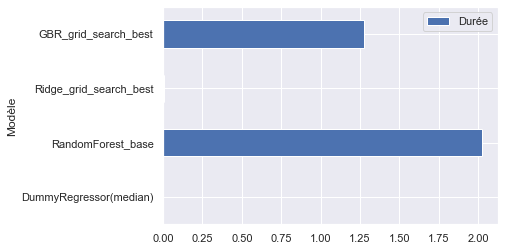

In [560]:
# Comparaison de la durée d'entraînement

df_duree = df_best[['Durée', 'Modèle']].head(4)
df_duree.plot.barh('Modèle','Durée')

L'écart des scores le jeu de test (R2) entre les modèles GradientBoostingRegressor et Ridge sont légèrement en faveur de GradientBoostingRegressor.Nous porterons notre choix final sur le modèle GradientBoostingRegressor avec les hypermaramétres optimisés à l'aide de GridSearch.

**Modèle retenu : GradientBoostingRegressor avec les hyperparamètres améliorés par GridSearchCV**

***Importance des variables***

In [593]:
# Definition de la variable cible et les features

df_with_e_imp = df_e_imp.copy()
df_with_e_imp.drop(["SiteEnergyUseWN(kBtu)"], axis=1,inplace=True)
target = ['SiteEnergyUseWN(kBtu)_log']

X = df_with_e_imp.iloc[:, ~df_with_e_imp.columns.isin(target)]
y = df_with_e_imp.loc[:,'SiteEnergyUseWN(kBtu)_log']

In [594]:
# Division en train et test, standartisation, encodage

X_train_std, X_test_std, y_train, y_test, encoded_df = preparation(X,y)

X_train : (1295, 20), X_test : (324, 20)
y_train : (1295,), y_test : (324,)


In [595]:
# Fit

gbs = GBR_grid_search_best
gbs.fit(X_train_std, y_train.values)

GradientBoostingRegressor(max_depth=2, n_estimators=500, random_state=0,
                          subsample=0.5)

In [596]:
# list des varaibles
feature_list = encoded_df.columns

# feature importances
importances = list(GBR_grid_search_best.feature_importances_)

# variables et importances
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# ordre des feature importances
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: PropertyGFABuilding(s)_log Importance: 0.51
Variable: ENERGYSTARScore      Importance: 0.09
Variable: TauxElectricity(kBtu) Importance: 0.05
Variable: BuildingAge          Importance: 0.04
Variable: TauxFirstUseGFA      Importance: 0.04
Variable: PrimaryPropertyType_Warehouse Importance: 0.03
Variable: LargestPropertyUseType_Warehouse Importance: 0.03
Variable: TauxParkingGFA       Importance: 0.02
Variable: TauxNaturalGas(kBtu) Importance: 0.02
Variable: NumberofFloors       Importance: 0.01
Variable: TauxSecondtUseGFA    Importance: 0.01
Variable: TauxThirdtUseGFA     Importance: 0.01
Variable: PrimaryPropertyType_Other Importance: 0.01
Variable: PrimaryPropertyType_Restaurant/Entertainment Importance: 0.01
Variable: PrimaryPropertyType_Retail/Store Importance: 0.01
Variable: LargestPropertyUseType_Datacenter Importance: 0.01
Variable: LargestPropertyUseType_Hospital Importance: 0.01
Variable: LargestPropertyUseType_Other Importance: 0.01
Variable: NumberofBuildings    Impo

In [598]:
feature_importance_dict = {}
feature_importance_dict["Variable"] = []
feature_importance_dict["Score"] = []

for name, score in zip(encoded_df.columns, GBR_grid_search_best.feature_importances_):
    feature_importance_dict["Variable"].append(name)
    feature_importance_dict["Score"].append(score)

best_GBR_energy_feature_importance = pd.DataFrame(feature_importance_dict, columns = ["Score"], index=feature_importance_dict["Variable"]).sort_values(by="Score", ascending = False, axis=0)
best_GBR_energy_feature_importance.head(20)

,Score
PropertyGFABuilding(s)_log,0.509
ENERGYSTARScore,0.090
TauxElectricity(kBtu),0.053
BuildingAge,0.042
TauxFirstUseGFA,0.040
LargestPropertyUseType_Warehouse,0.032
PrimaryPropertyType_Warehouse,0.027
TauxParkingGFA,0.017
TauxNaturalGas(kBtu),0.017
LargestPropertyUseType_Other,0.014


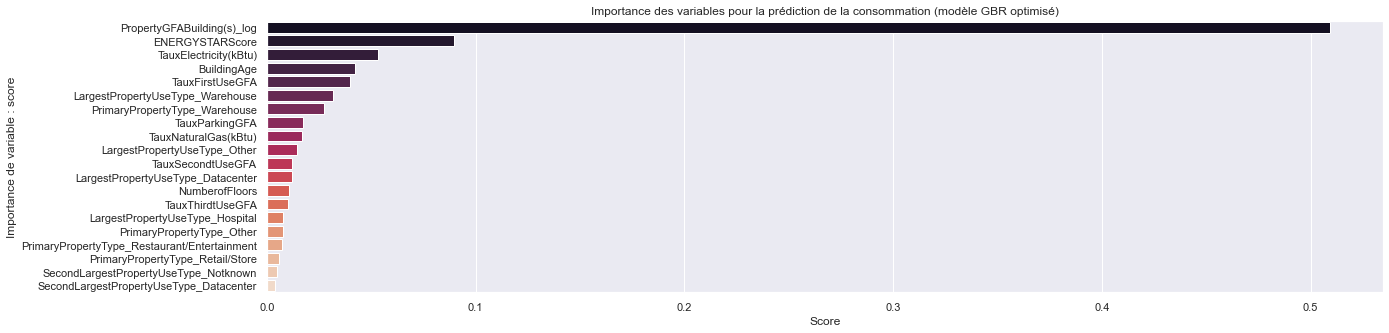

In [611]:
feature_grapf = best_GBR_energy_feature_importance.head(20)
fig = plt.figure(figsize=(20, 5))

sns.barplot(data=feature_grapf,
            y=feature_grapf.index,
            x='Score',
            palette='rocket')
plt.ylabel('Importance de variable : score')
plt.title('Importance des variables pour la prédiction de la consommation (modèle GBR optimisé)')
plt.show()

***Analyse des erreurs sur les prédictions, modèle GradientBoostingRegressor optimisé***

In [599]:
# Predictions avec le train set
y_train_pred = gbs.predict(X_train_std)

# Prédictions avec le test set
y_test_pred = gbs.predict(X_test_std)

# DataFrame du jeu de test
df_error_test = pd.DataFrame({'y_test_pred': y_test_pred,
                              'y_test': y_test})
df_error_test['erreur_abs'] = abs(y_test_pred - y_test)
df_error_test['erreur_sens'] = y_test_pred - y_test


# DataFrame du jeu d'entraînement
df_error_train = pd.DataFrame({'y_train_pred': y_train_pred,
                               'y_train': y_train})
df_error_train['erreur_abs'] = abs(y_train_pred - y_train)
df_error_train['erreur_sens'] = y_train_pred - y_train

In [600]:
df_error_test

,y_test_pred,y_test,erreur_abs,erreur_sens
76,15.313,15.525,0.212,-0.212
526,15.311,15.432,0.121,-0.121
1255,14.903,14.503,0.401,0.401
955,14.608,13.500,1.108,1.108
229,16.592,17.003,0.411,-0.411
...,...,...,...,...
353,16.376,15.855,0.522,0.522
1000,14.516,14.372,0.143,0.143
1339,14.121,15.440,1.319,-1.319
563,15.915,15.705,0.210,0.210


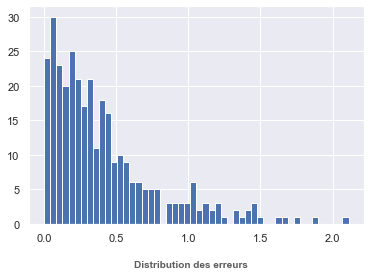

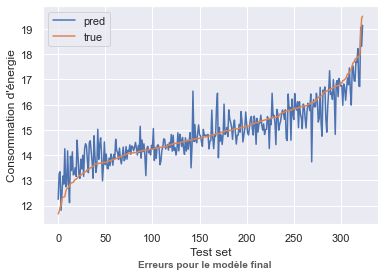

In [606]:
 # Histogramme des absolute_error
plt.hist(df_error_test['erreur_abs'], bins=50)
plt.suptitle(t='Distribution des erreurs',
                     y=0,
                     fontsize=10,
                     alpha=0.75,
                     weight='bold',
                     ha='center')
plt.show()

    
# affichage des erreurs
df_res = pd.DataFrame({'true': y_test, 'pred': y_pred})
df_res = df_res.sort_values('true')
plt.plot(df_res['pred'].values, label='pred')
plt.plot(df_res['true'].values, label='true')
plt.xlabel('Test set')
plt.ylabel("Consommation d'énergie")
plt.suptitle(t='Erreurs pour le modèle final',
                     y=0,
                     fontsize=10,
                     alpha=0.75,
                     weight='bold',
                     ha='center')
plt.legend()
plt.show()

In [607]:
df_error_test['erreur_abs'].describe()

count   324.000
mean      0.408
std       0.380
min       0.000
25%       0.137
50%       0.301
75%       0.542
max       2.111
Name: erreur_abs, dtype: float64

In [608]:
# Erreur maximale

df_error_max = df_error_test[df_error_test['erreur_abs']
                             == df_error_test['erreur_abs'].max()]
df.iloc[df_error_max.index.to_list(), :]

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,...,SiteEnergyUseWN(kBtu)_log,TotalGHGEmissions_log,TauxParkingGFA,TauxFirstUseGFA,TauxSecondtUseGFA,TauxThirdtUseGFA,TauxSteamUse(kBtu),TauxElectricity(kBtu),TauxNaturalGas(kBtu),PropertyGFABuilding(s)_log
442,624,NonResidential,Other,98134.000,2,GREATER DUWAMISH,2,2,Manufacturing/Industrial Plant,Notknown,...,14.624,2.812,0.000,1.138,0.000,0.000,0.000,1.000,0.000,11.740


In [609]:
# erreur sur le jeu de test de plus de 95%

df_erreur_sup95 = df_error_test[df_error_test['erreur_abs']
                                > df_error_test['erreur_abs'].quantile(0.95)]
df_erreur_sup95

,y_test_pred,y_test,erreur_abs,erreur_sens
1262,14.901,16.370,1.469,-1.469
581,14.659,13.341,1.318,1.318
745,12.965,11.763,1.202,1.202
1356,15.533,16.960,1.427,-1.427
1321,13.981,12.354,1.627,1.627
619,16.157,14.794,1.363,1.363
725,14.047,15.285,1.237,-1.237
182,15.019,16.539,1.519,-1.519
412,16.710,14.842,1.868,1.868
442,16.735,14.624,2.111,2.111


Parmi les plus importantes erreurs de prédiction, nous remarquons les cas de sous-estimation et de surestimation de la consommmantion.

In [610]:
# bâtiments avec erreur sur le jeu de test de plus de 95%

df_sup95 = df1.iloc[df_erreur_sup95.index.to_list(), :]
df_sup95

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,...,SiteEnergyUseWN(kBtu),SiteEnergyUseWN(kBtu)_log,TauxParkingGFA,TauxFirstUseGFA,TauxSecondtUseGFA,TauxThirdtUseGFA,TauxSteamUse(kBtu),TauxElectricity(kBtu),TauxNaturalGas(kBtu),PropertyGFABuilding(s)_log
1262,NonResidential,Retail/Store,98118.000,2,SOUTHEAST,1,1,Retail/Store,Retail/Store,Notknown,...,12869714.000,16.370,0.000,0.758,0.655,0.000,0.000,0.431,0.569,10.542
581,NonResidential,Warehouse,98106.000,1,DELRIDGE,1,1,Warehouse,Office,Notknown,...,622185.688,13.341,0.000,0.966,0.034,0.000,0.000,1.000,0.000,12.047
745,NonResidential,Other,98144.000,2,SOUTHEAST,1,2,Other,Notknown,Notknown,...,128383.898,11.763,0.000,1.000,0.000,0.000,0.000,1.000,0.000,9.906
1356,NonResidential,Other,98112.000,3,EAST,1,3,Restaurant/Entertainment,Notknown,Notknown,...,23204450.000,16.960,0.000,1.000,0.000,0.000,0.000,0.331,0.669,11.174
1321,NonResidential,Other,98104.000,7,DOWNTOWN,1,3,Other,Notknown,Notknown,...,231847.094,12.354,0.000,1.000,0.000,0.000,0.000,0.341,0.659,10.008
619,Campus,Other,98155.000,2,GREATER DUWAMISH,3,1,Manufacturing/Industrial Plant,Notknown,Notknown,...,2660376.750,14.794,0.000,1.000,0.000,0.000,0.000,0.161,0.839,10.035
725,NonResidential,Other,98116.000,1,SOUTHWEST,1,2,Warehouse,Restaurant/Entertainment,Restaurant/Entertainment,...,4345884.500,15.285,0.000,0.333,0.333,0.209,0.000,0.193,0.807,9.938
182,NonResidential,Other,98101.000,7,DOWNTOWN,1,2,Restaurant/Entertainment,Notknown,Notknown,...,15230290.000,16.539,0.000,1.000,0.000,0.000,0.000,0.710,0.290,11.148
412,NonResidential,Other,98134.000,2,GREATER DUWAMISH,1,1,Other,Notknown,Notknown,...,2789899.000,14.842,0.000,1.000,0.000,0.000,0.000,0.152,0.848,11.614
442,NonResidential,Other,98134.000,2,GREATER DUWAMISH,2,2,Manufacturing/Industrial Plant,Notknown,Notknown,...,2244317.000,14.624,0.000,1.138,0.000,0.000,0.000,1.000,0.000,11.740


Les plus grosses erreurs concernent les bâtiments de differents types (Restaurant, Retail, Warehouse, Inductrial Plant, Other). Ils ne touchent pas le même type de bâtiment selon la surface, le nombre d'étageou type d'énergie.

***Test des differents encodeurs***

In [619]:
# Création d'un dataframe stockant les résultats des test

df_test_enc = pd.DataFrame()

In [623]:
# Definition de la variable cible et les features

df_with_e_imp = df_e_imp.copy()
df_with_e_imp.drop(["SiteEnergyUseWN(kBtu)"], axis=1,inplace=True)
target = ['SiteEnergyUseWN(kBtu)_log']

X = df_with_e_imp.iloc[:, ~df_with_e_imp.columns.isin(target)]
y = df_with_e_imp.loc[:,'SiteEnergyUseWN(kBtu)_log']

In [624]:
# Découpage du jeu de données en train et test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
print(f'X_train : {X_train.shape}, X_test : {X_test.shape}')
print(f'y_train : {y_train.shape}, y_test : {y_test.shape}')

X_train : (1295, 20), X_test : (324, 20)
y_train : (1295,), y_test : (324,)


Test encodeurs 1 : num : RobustScaler / cat : OneHotEncoder

In [625]:
cols_num=X.select_dtypes('number').columns
cols_cat=X.select_dtypes('object').columns

# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', OneHotEncoder(handle_unknown='ignore')),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler()),  # standardization
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [615]:
def regression_test(regression_model, X_train, X_test, y_train, y_test, df_results, titre):

    # Entraînement du modèle
    regression_model.fit(X_train, y_train)
        
    # Prédictions avec le test set
    y_pred = regression_model.predict(X_test)

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = round(sqrt(mse),2)
    r2 = round(r2_score(y_test, y_pred),2)
    errors = abs(y_pred - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape

    # Cross validation
    scoring = ['r2']
    scores = cross_validate(regression_model, X_train, y_train, cv=3,
                            scoring=scoring, return_train_score=True)

    # Performances de modèle
    df_results = df_results.append(pd.DataFrame({
         'Modèle': [titre],
         'R2': [round(r2,2)],
         'RMSE': [round(rmse,2)],
         'Erreur moy': [round(np.mean(errors),2)],
         'Test R2 CV': [round(scores['test_r2'].mean(),2)],
         'Train R2 CV':[round(scores['train_r2'].mean(),2)],
     }), ignore_index=True)


    return df_results, y_pred

In [626]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', gbs)])

df_test_enc, y_pred_enc_test1 = regression_test(gb,
                                                                 X_train, X_test,
                                                                 y_train, y_test,
                                                                 df_test_enc,
                                                                 'GBR_enc_test1')

In [627]:
# résultats de test encodeurs 1 : RobustScaler / OneHot 
df_test_enc

,Modèle,R2,RMSE,Erreur moy,Test R2 CV,Train R2 CV
0,GBR_enc_test1,0.800,0.570,0.410,0.770,0.930


Test encodeurs 2 : num : RobustScaler / cat : TargetEncoder

In [628]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', TargetEncoder()) # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler()),  # standardization
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

C:\Users\mfila\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\mfila\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [631]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', gbs)])

df_test_enc, y_pred_enc_test2 = regression_test(gb,
                                                                 X_train, X_test,
                                                                 y_train, y_test,
                                                                 df_test_enc,
                                                                 'GBR_enc_test2')

C:\Users\mfila\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\mfila\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\mfila\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\mfila\anaconda3\lib\site-packages\category_encoders\target_enco

In [633]:
# résultats de test encodeurs 2

df_test_enc

,Modèle,R2,RMSE,Erreur moy,Test R2 CV,Train R2 CV
0,GBR_enc_test1,0.800,0.570,0.410,0.770,0.930
1,GBR_enc_test2,0.810,0.570,0.400,0.760,0.930


Test encodeurs 3: num : MinMaxScaler / cat : OneHotEncoder

In [640]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', OneHotEncoder(handle_unknown='ignore')),  # target encoding
])


# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),  # standardization
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [641]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', gbs)])

df_test_enc, y_pred_enc_test2 = regression_test(gb,
                                                                 X_train, X_test,
                                                                 y_train, y_test,
                                                                 df_test_enc,
                                                                 'GBR_enc_test3')

In [642]:
df_test_enc

,Modèle,R2,RMSE,Erreur moy,Test R2 CV,Train R2 CV
0,GBR_enc_test1,0.800,0.570,0.410,0.770,0.930
1,GBR_enc_test2,0.810,0.570,0.400,0.760,0.930
2,GBR_enc_test3,0.810,0.560,0.410,0.770,0.930


Les differents types de standartisation et encodage ne change pas les résultats du modèle.

***Analyse d'effet des outliers sur les prédictions***

In [570]:
# création du dataset sans outliers, utilisons la variable 'Outliers'

df_test_out = pd.concat([df_e_imp,df['Outlier']],axis=1)
df_test_out.drop('SiteEnergyUseWN(kBtu)',axis=1,inplace=True)
df_test_out.Outlier.value_counts()

Not             1602
Low outlier       15
High outlier       2
Name: Outlier, dtype: int64

In [571]:
# supprimons 17 outliers

df_test_out.drop(df_test_out.loc[df_test_out['Outlier']=='High outlier'].index, inplace=True)
df_test_out.drop(df_test_out.loc[df_test_out['Outlier']=='Low outlier'].index, inplace=True)

In [572]:
# drop de la colonne non utile
df_test_out.drop('Outlier',axis=1,inplace=True)

# verification de taille du dataset
df_test_out.shape

(1602, 21)

In [573]:
# supprimer les outliers extrêmes pour la target

df_test_no_out = df_test_out[(df_test_out['SiteEnergyUseWN(kBtu)_log']
                                < df_test_out['SiteEnergyUseWN(kBtu)_log'].quantile(0.95))&
                         (df_test_out['SiteEnergyUseWN(kBtu)_log']
                                 > df_test_out['SiteEnergyUseWN(kBtu)_log'].quantile(0.05))]
df_test_no_out.shape

(1440, 21)

In [574]:
# Definition de la variable cible et les features

target = ['SiteEnergyUseWN(kBtu)_log']

X = df_test_no_out.iloc[:, ~df_test_no_out.columns.isin(target)]
y = df_test_no_out.loc[:,'SiteEnergyUseWN(kBtu)_log']

In [575]:
# train, test, standartisation, encodage 

X_train_std, X_test_std, y_train, y_test, encoded_df = preparation(X,y)

X_train : (1152, 20), X_test : (288, 20)
y_train : (1152,), y_test : (288,)


In [583]:
model_to_comp = [GBR_grid_search_best, GradientBoostingRegressor(random_state=0)]

In [584]:
# test 6 : model final sur le jeu de données sans outliers pour le target

df_comp6 = model_comp(model_to_comp, X_train_std, X_test_std, y_train, y_test)
df_comp6

,Modèle,R2,RMSE,Erreur moy,Durée,Test R2 CV,Train R2 CV
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.760,0.480,0.340,2.491,0.700,0.920
1,([DecisionTreeRegressor(criterion='friedman_ms...,0.760,0.470,0.350,1.191,0.700,0.880


Résultats de test 6 : Pas d'amelioration de R2 après la suppression des outliers pour le target.

Caractéristiques du modèle final choisi :

- dataframe complet avec la variable ENERGYSTARScore complétée par Itirative imputer,
- prétraitement des variables : RobustScaler et OneHotEncoder,
- hyperparamètres du modèle : 
   GradientBoostingRegressor(max_depth=2, n_estimators=500, random_state=0, subsample=0.5), 